## TF2 Fashion MNIST - LR Scheduling

In [2]:
import numpy as np
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)
import tensorflow as tf
import matplotlib.pyplot as plt

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    

tf_version = 'TF '+tf.__version__
print(tf_version)

TF 2.5.0


In [3]:
mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train=X_train.reshape(-1,28,28,1)
X_val=X_val.reshape(-1,28,28,1)

print("Training   X:",X_train.shape, 'y:', y_train.shape)
print("Validation X:",X_val.shape, 'y:', y_val.shape)
print("X min:",np.min(X_train))
print("X max:",np.max(X_train))

X_train, X_val = X_train / 255.0, X_val / 255.0

print("After normalization:")
print("X min:",np.min(X_train))
print("X max:",np.max(X_train))

Training   X: (60000, 28, 28, 1) y: (60000,)
Validation X: (10000, 28, 28, 1) y: (10000,)
X min: 0
X max: 255
After normalization:
X min: 0.0
X max: 1.0


In [50]:
def getModelCNN():
    model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(8,(3,3), activation='relu',input_shape=(28, 28,1)),
                tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(10, activation='softmax')],name='CNN')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [51]:
def vizualize_results(models,histories):
    plt.figure(figsize=(20,10))
    ax1=plt.subplot(121)

    srtd = sorted(zip(models,histories), key=lambda x: max(x[1].history['val_accuracy']))[::-1]
    for name, history in srtd:
        plt.plot(history.history['accuracy'], label=name+' %.1f%%'%(100*max(history.history['accuracy'])))
        plt.title('Training accuracy')
        plt.legend()
    plt.subplot(122, sharey=ax1)
    for name, history in srtd:
        plt.plot(history.history['val_accuracy'], label=name+' %.1f%%'%(100*max(history.history['val_accuracy'])))
        plt.title('Validation accuracy')
        plt.legend();

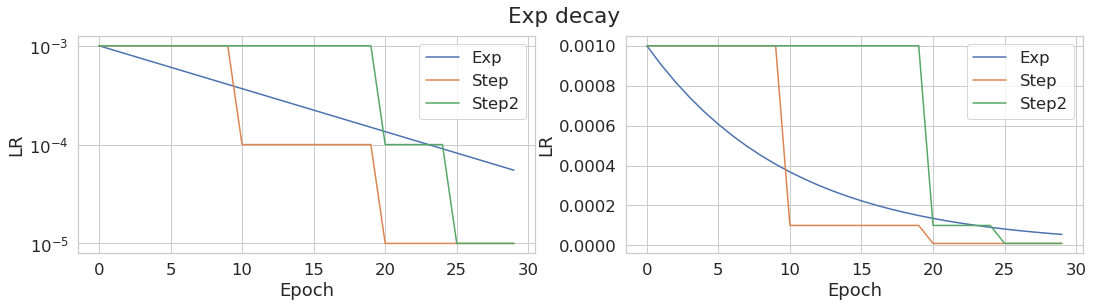

In [52]:
def scheduleExpDecay(epoch):
    start_lr = 0.001
    decay = 0.1
    return start_lr * np.exp(-decay*epoch)

def scheduleStep(epoch):
    start_lr = 0.001
    thresh=10
    mult=0.1
    return start_lr*(mult**(epoch//thresh))

def scheduleStep2(epoch):
    start_lr = 0.001
    threshs=[20,25]
    mult=0.1
    lr = start_lr
    for th in threshs:
        if epoch>=th:
            lr*=mult
    return lr


plt.figure(figsize=(18,4))
plt.subplot(121)
plt.plot(scheduleExpDecay(np.arange(30)),label='Exp')
plt.plot(scheduleStep(np.arange(30)),label='Step')
plt.plot([scheduleStep2(_) for _ in range(30)],label='Step2')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.legend()

plt.subplot(122)
plt.plot(scheduleExpDecay(np.arange(30)),label='Exp')
plt.plot(scheduleStep(np.arange(30)),label='Step')
plt.plot([scheduleStep2(_) for _ in range(30)],label='Step2')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.legend()
plt.suptitle('Exp decay');

None
<function scheduleExpDecay at 0x7f2fa80a9830>
<function scheduleStep at 0x7f2fa82079e0>
<function scheduleStep2 at 0x7f2fa831ff80>


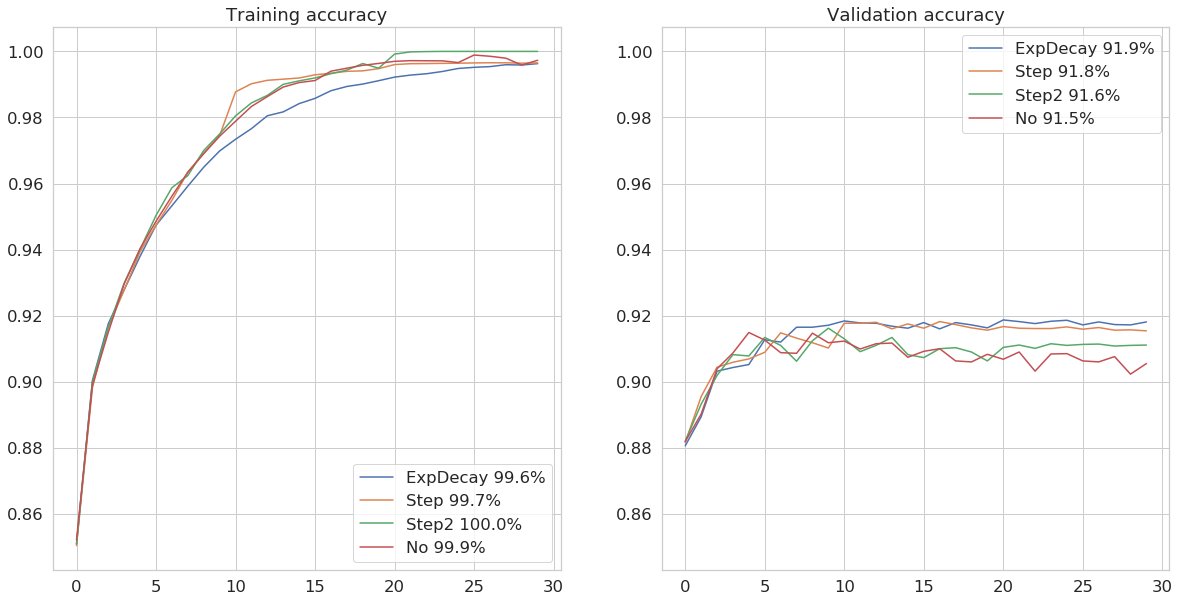

In [53]:
epochs=30
batch_size=128

histories=[]

schedulers=[None,scheduleExpDecay,scheduleStep,scheduleStep2]
schedulers_names=['No','ExpDecay','Step','Step2']

for s in schedulers:
    model=getModelCNN()
    print(s)
    
    callbacks=[]
    if s is not None:
        callbacks.append(tf.keras.callbacks.LearningRateScheduler(s))
    
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val,y_val),
                        verbose=0,
                        callbacks=callbacks)
    del model
    histories.append(history)
vizualize_results(schedulers_names,histories)

# PyTorch

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 128, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(73728, 10))

    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output

    
model = Net()
x = torch.randn(1, 1, 28, 28)
out = model(x)
print('Params: %6d'%sum(p.numel() for p in model.parameters() if p.requires_grad),model._get_name())
del model

Params: 746714 Net


In [45]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(use_cuda,device)

epochs=30
batch_size=128

transform=transforms.Compose([
    transforms.ToTensor(),
    ])

train_set = datasets.FashionMNIST('.', train=True, download=True, transform=transform)
val_set = datasets.FashionMNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

True cuda


In [46]:
def train_model(model, optimizer, scheduler, train_loader, val_loader, epochs, batch_size, step_each_batch=False):
    train_losses=[]
    val_losses=[]
    train_accs=[]
    val_accs=[]

    for epoch in tqdm(list(range(1, epochs + 1))):
        model.train()
        train_loss=0
        correct=0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if step_each_batch:
                scheduler.step()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().detach() # instead of item -> https://pytorch-lightning.readthedocs.io/en/latest/guides/speed.html#things-to-avoid
            train_loss+=loss.detach()
            
        
        if not step_each_batch:
            scheduler.step()
        train_loss/=len(train_loader)
        acc = correct / float(len(train_loader.dataset))
        train_losses.append(train_loss)
        train_accs.append(acc)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.nll_loss(output, target, reduction='sum').detach()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().detach()


        val_loss /= len(val_loader.dataset)
        val_acc = correct / float(len(val_loader.dataset))
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    return train_losses, val_losses,train_accs,val_accs
#         print("Epoch %3d Train loss: %f Acc: %f Val   loss: %f Acc: %f"%(epoch, train_loss, acc, val_loss, val_acc))


In [47]:
results=[]

scheduler_names = ['No', 'StepLR', 'ExponentialLR','OneCycleLR']

model = Net().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1) # no scheduler
train_losses, val_losses,train_accs,val_accs = train_model(model, optimizer, scheduler, train_loader, val_loader, epochs, batch_size)
results.append((train_losses, val_losses,train_accs,val_accs))
del model

model = Net().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_losses, val_losses,train_accs,val_accs = train_model(model, optimizer, scheduler, train_loader, val_loader, epochs, batch_size)
results.append((train_losses, val_losses,train_accs,val_accs))
del model

model = Net().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
train_losses, val_losses,train_accs,val_accs = train_model(model, optimizer, scheduler, train_loader, val_loader, epochs, batch_size)
results.append((train_losses, val_losses,train_accs,val_accs))
del model

model = Net().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs)
train_losses, val_losses,train_accs,val_accs = train_model(model, optimizer, scheduler, train_loader, val_loader, epochs, batch_size,step_each_batch=True)
results.append((train_losses, val_losses,train_accs,val_accs))
del model

100%|██████████| 30/30 [02:53<00:00,  5.77s/it]


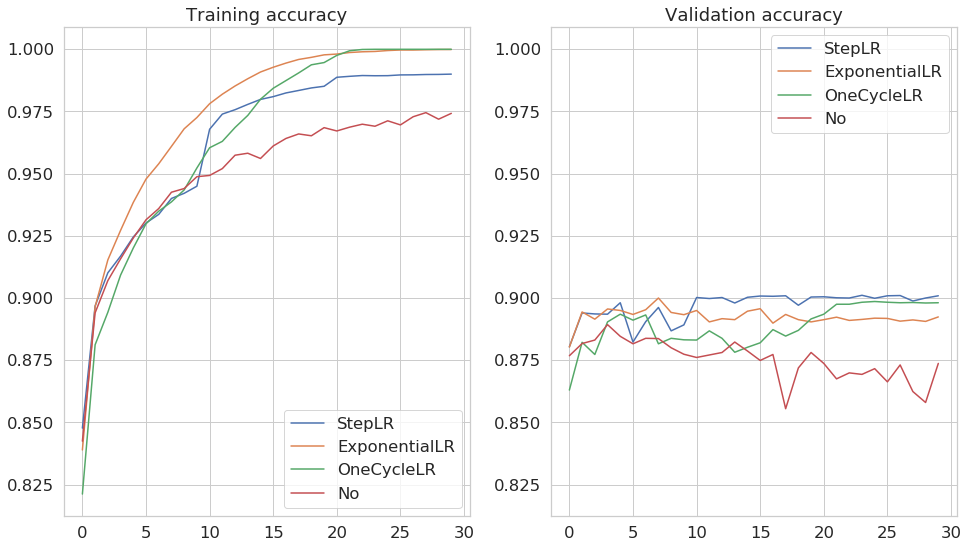

In [48]:
plt.figure(figsize=(16,9))
ax1=plt.subplot(121)
srtd = sorted(zip(scheduler_names,results), key=lambda x: max(x[1][3]))[::-1]
for n, history in srtd:
    plt.plot(history[2], label=n)
    plt.title('Training accuracy')
    plt.legend()
plt.subplot(122, sharey=ax1)
for n, history in srtd:
    plt.plot(history[3], label=n)
    plt.title('Validation accuracy')
    plt.legend();